# Gamma spec analysis

In [3]:
from scipy.signal import find_peaks, peak_prominences, savgol_filter, peak_widths, argrelmin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gs_analysis as ga

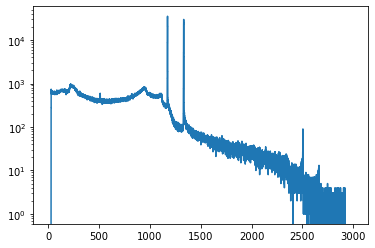

In [4]:
path = "test_data/Co_60_raised_1.spe"
spec = ga.get_spect(path)
spec.ebins = ga.generate_ebins(spec)
ga.plot_spec(spec.counts, erg=spec.ebins)

[1398 3210 3646]


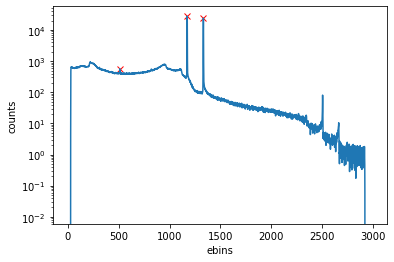

In [5]:
def sp_peak_finder(x, prominence, wlen):

    sf = ga.five_point_smooth(x)
    smooth = np.array(sf)
    sf2 = ga.five_point_smooth(smooth)
    smooth2 = np.array(sf2)
    peaks,_ = find_peaks(sf2, prominence = prominence, wlen = wlen)
    
    return(smooth2, peaks)

def peak_identifier(smooth_counts, ebins, peaks):
    plt.plot(ebins[peaks], smooth_counts[peaks], "xr"); plt.plot(ebins, smooth_counts)
    plt.xlabel('ebins')
    plt.ylabel('counts')
    plt.yscale('log') 
    plt.show
    
smoothed_counts_sp, peaks_sp = sp_peak_finder(spec.counts, 90, 10)
print(peaks_sp)

plot_sp = peak_identifier(smoothed_counts_sp, spec.ebins, peaks_sp)

In [6]:
proms = peak_prominences(spec.counts, peaks_sp)[0]
print(proms)

#why is the first one zero? surely if it was 0 it wouldnt show up when i put the prominence to be at least 90??

[    0. 35274. 29723.]


C:\Users\gai72996\AppData\Local\Temp/ipykernel_17784/4077324633.py:1: PeakPropertyWarning: some peaks have a prominence of 0
  proms = peak_prominences(spec.counts, peaks_sp)[0]


## Diff version
smooth, find maxima with scipy or 2nd deriv, then ?
(https://arxiv.org/pdf/hep-ex/9506013.pdf)

C:\Users\gai72996\AppData\Local\Temp/ipykernel_17784/1768425881.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mid_point = ((peak_start + peak_end) / 2).astype(np.int)


[3210 3645]


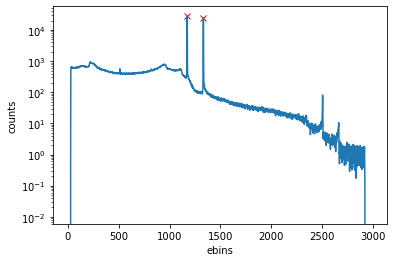

In [7]:
#fits a polynomial to the curve in the specified window
#then for the peaks - uses 2nd derivative, looks for places where 2nd deriv is at least half its max size
#then finds start and end points then mid points
#do the same method with the smoother from steve instead 

def peak_finder_savgol(x, wlen):
    smooth_sig = ga.five_point_smooth(x)
    smooth_signal = np.array(smooth_sig)
    smooth_sig2 = ga.five_point_smooth(smooth_signal)
    smooth_signal2 = np.array(smooth_sig2)
    d2x = savgol_filter(smooth_signal2, window_length=wlen, polyorder=2, deriv=2)
    max_d2x = np.max(np.abs(d2x))
    large = np.where(np.abs(d2x) > max_d2x/2)[0]
    peak_width = np.diff(large) > wlen
    peak_start= np.insert(large[1:][peak_width], 0, large[0])
    peak_end = np.append(large[:-1][peak_width], large[-1])
    mid_point = ((peak_start + peak_end) / 2).astype(np.int)

    return(smooth_signal2, mid_point, peak_start, peak_end, peak_width) 

smooth_counts_savgol, peaks_savgol, peak_start, peak_end, peak_width = peak_finder_savgol(spec.counts, 11)
print(peaks_savgol)

plot_savgol = peak_identifier(smooth_counts_savgol, spec.ebins, peaks_savgol)

#this one also uses the smoothing function on top of the savgol - takes out even more noise
#window length for savgol needs to be odd

### Savgol

In [8]:
#counts for the savgol func as peak start and end is found so doesnt need gaussian or whatever
smooth_counts_savgol, peaks_savgol, peak_start, peak_end, peak_width = peak_finder_savgol(spec.counts, 11)

print('peaks', peaks_savgol)

s = peak_start
e = peak_end
print('peak start', s)
print('peak end', e)

#net__counts for savgol peak 1 (iterate later)
savgol_counts = ga.net_counts(smooth_counts_savgol, s[0], e[0], m=1)
print('savgol peak at 3210, net counts = ', savgol_counts)

peaks [3210 3645]
peak start [3208 3644]
peak end [3212 3647]
savgol peak at 3210, net counts =  50461.09465020575


C:\Users\gai72996\AppData\Local\Temp/ipykernel_17784/1768425881.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mid_point = ((peak_start + peak_end) / 2).astype(np.int)


### Scipy peak finder counts

In [9]:
#function to return counts (no need to plot)
#maybe get it to return ebin value instead of peak index?
#the description of this is bad but i dont know how to say it better
def peak_counts(peaks, index, smooth_counts, ebins):
    """ Index is the peak array index for the peak that counts is required for
        i.e [0], NOT the peak index itself i.e [3210]
        Returns the index of the peak and its calculated count
    """    
    x, y = ga.get_peak_roi(peaks[index], smooth_counts, ebins, offset=10)
    
    length = len(x)
    start_pos = x[0]
    end_pos = x[length - 1]
    start, = np.where(ebins == start_pos)
    end, = np.where(ebins == end_pos)
    
    counts = ga.net_counts(smooth_counts, start[0], end[0], m=1)
    
    return(peaks[index], counts)

sp_peak_index, sp_counts = peak_counts(peaks_sp, 1, smoothed_counts_sp, spec.ebins)
print('peak at', sp_peak_index, ', net counts =', sp_counts)

peak at 3210 , net counts = 190260.4732510288


[1398 3210 3646]
start index [3200]
end index [3219]
start count 510.6419753086419
end count 496.58024691358014
net counts scipy 190260.4732510288


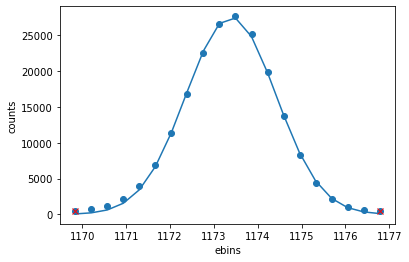

In [11]:
#for the first function 2nd peak (first on the savgol one above)
#also note - idk why but the gaussian doesnt fit the 511 peak
print(peaks_sp)

x, y = ga.get_peak_roi(peaks_sp[1], smoothed_counts_sp, spec.ebins, offset=10) 

params = ga.fit_peak(x, y)
#print(params) #[0] is a [1] is x0 [2] is sigma for ga.gaussian(i think)

length = len(x)
start_pos = x[0]
end_pos = x[length - 1]
start, = np.where(spec.ebins == start_pos)
end, = np.where(spec.ebins == end_pos)
print('start index',start)
print('end index', end)

sy = np.interp(start_pos, spec.ebins, smoothed_counts_sp)
print('start count',sy)
ey = np.interp(end_pos, spec.ebins, smoothed_counts_sp)
print('end count',ey)


counts_sp = ga.net_counts(smoothed_counts_sp, start[0], end[0], m=1)
print('net counts scipy',counts_sp)

plt.figure(figsize=(6, 4))
plt.scatter(x, y)
plt.ylabel('counts')
plt.xlabel('ebins')
plt.plot(x, ga.gaussian(x, params[0], params[1], params[2]))
plt.plot(start_pos, sy, 'xr')
plt.plot(end_pos, ey, 'xr')
plt.plot()
plt.show()

1172.76086 22538.592592592588


<function matplotlib.pyplot.show(close=None, block=None)>

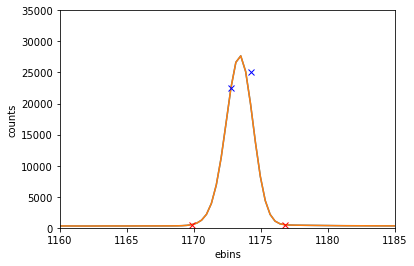

In [13]:
#scipy
ebins = spec.ebins
a = ebins[3200]
b = ebins[3219]
sy = np.interp(start_pos, ebins, smoothed_counts_sp)
ey = np.interp(end_pos, ebins, smoothed_counts_sp)

#savgol
sav_c = smooth_counts_savgol[3208: 3212]
s = peak_start
e = peak_end
s_s = sav_c[0]
s_e = sav_c[len(sav_c)-1]
sx = ebins[s[0]]
ex = ebins[e[0]]
print(sx, s_s)

#plotting to see start and end pos differences 
plt.plot(ebins, smoothed_counts_sp)
plt.plot(ebins, smooth_counts_savgol)
plt.xlabel('ebins')
plt.ylabel('counts')
plt.xlim([1160, 1185])
plt.ylim([0, 35000]) 
plt.plot(sx, s_s, 'xb')#savgol
plt.plot(ex, s_e, 'xb')
plt.plot(a, sy, 'xr')#scipy
plt.plot(b, ey, 'xr')
plt.show

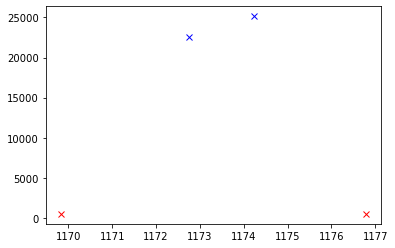

In [14]:
plt.plot(a, sy, 'xr')
plt.plot(b, ey, 'xr')

plt.plot(sx, s_s, 'xb')
plt.plot(ex, s_e, 'xb')

## Comparison for count issue

In [17]:
#comparison stuff to see where the count issue is 
savgol_counts = ga.net_counts(smooth_counts_savgol, s[0], e[0], m=1)
print('savgol peak at 3210, net counts = ', savgol_counts)
print('3210 peak start savgol', s[0])
print('3210 peak end savgol', e[0])
savgol_bg = ga.calc_bg(smooth_counts_savgol, s[0], e[0], m=1)
print('savgol bg = ', savgol_bg)
sav_gc = ga.gross_count(smooth_counts_savgol, s[0], e[0])
print('savgol gc = ', sav_gc)
print('savgol peak counts', smooth_counts_savgol[3208: 3212])

low_sum_sav = sum(smooth_counts_savgol[s[0] - 2:s[0]])
print('low sum range sav', smooth_counts_savgol[s[0] - 2:s[0]])
print('sav low sum', low_sum_sav)
high_sum_sav = sum(smooth_counts_savgol[e[0]:e[0] + 2])
print('sav high sum', high_sum_sav)
savbg = (low_sum_sav + high_sum_sav) * ((e[0] - s[0] + 1) / 6)
print('savbg', savbg)


counts_sp = ga.net_counts(smoothed_counts_sp, start[0], end[0], m=1)
print('scipy peak at 3210 net counts = ', counts_sp)
print('3210 peak start scipy',start)
print('3210 peak end scipy', end)
sp_bg = ga.calc_bg(smoothed_counts_sp, start[0], end[0], m=1)
print('scipy bg = ', sp_bg)
sp_gc = ga.gross_count(smoothed_counts_sp, start[0], end[0])
print('scipy gc = ', sp_gc)
print('scipy peak counts', smoothed_counts_sp[3200: 3219])

low_sum_sp = sum(smoothed_counts_sp[start[0] - 2:start[0]])
print('low sum range sp', smoothed_counts_sp[start[0] - 2:start[0]])
print('sp low sum', low_sum_sp)
high_sum_sp = sum(smoothed_counts_sp[end[0]:end[0] + 2])
print('sp high sum', high_sum_sp)
spbg = (low_sum_sp + high_sum_sp) * ((end[0] - start[0] + 1) / 6)
print('spbg', spbg)






savgol peak at 3210, net counts =  50461.09465020575
3210 peak start savgol 3208
3210 peak end savgol 3212
savgol bg =  51538.8683127572
savgol gc =  101999.96296296295
savgol peak counts [22538.59259259 26636.85185185 27674.13580247 25150.38271605]
low sum range sav [11303.01234568 16874.62962963]
sav low sum 28177.641975308637
sav high sum 33669.0
savbg 51538.8683127572
scipy peak at 3210 net counts =  190260.4732510288
3210 peak start scipy [3200]
3210 peak end scipy [3219]
scipy bg =  5598.600823045267
scipy gc =  195859.07407407407
scipy peak counts [  510.64197531   749.03703704  1230.56790123  2174.32098765
  3925.82716049  6887.85185185 11303.01234568 16874.62962963
 22538.59259259 26636.85185185 27674.13580247 25150.38271605
 19928.50617284 13740.49382716  8262.7654321   4391.12345679
  2152.56790123  1079.79012346   647.97530864]
low sum range sp [341.85185185 395.09876543]
sp low sum 736.9506172839506
sp high sum 942.6296296296296
spbg 5598.600823045267


## Playing about with second derivative stuff

[  1123.82997748   1734.38724155   3375.66369273   5997.44980498
   9129.27134422  11242.99207015   9170.12823452   1157.85988345
 -11827.05227754 -23579.3409697  -27639.25624451 -20785.68418579
  -7177.79549927   5896.39377791  12619.07630629  12539.94727426
   8730.18187247   4674.27297604   1971.10563538    807.63387057]
[ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.
  1.  1.]
Roots = [1173.41521767]


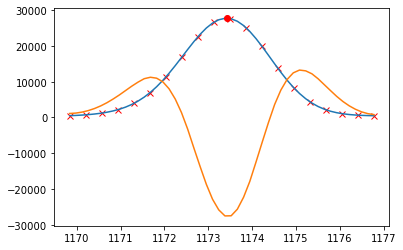

In [18]:
from scipy.interpolate import UnivariateSpline

x, y = ga.get_peak_roi(peaks_sp[1], smoothed_counts_sp, ebins, offset=10)

y_spl = UnivariateSpline(x,y,s=0,k=4)
plt.plot(x,y,'xr')
x_range = np.linspace(x[0],x[-1])
plt.plot(x_range,y_spl(x_range))

y_spl_2d = y_spl.derivative(n=2)
plt.plot(x_range,y_spl_2d(x_range))
d2 = y_spl_2d(x)
print(d2)
sign_change = np.sign(d2)
print(sign_change)
print('Roots = {}'.format(y_spl.derivative().roots()))
minmax = y_spl.derivative().roots()
plt.plot(minmax, y_spl(minmax), 'ro ')


#second deriv could be useful for hidden peaks though as it can amplify it